# Clustering audio à partir des fichiers chroma

On commence ici par étudier le datatset Cross-composer composé d'oeuvres de 11 compositeurs, l'objectif étant d'élargir avec le dataset Cross-era qui pourrait permettre de faire du clustering sur des périodes musicales.

In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

In [2]:
filename = "cross-composer\chroma-nnls_01_bach.csv"
li_notes = ['time','A','A#','B','C','C#','D','D#','E','F','F#','G','G#']

<>:1: SyntaxWarning: invalid escape sequence '\c'
<>:1: SyntaxWarning: invalid escape sequence '\c'
C:\Users\PCAJM\AppData\Local\Temp\ipykernel_7792\2910331894.py:1: SyntaxWarning: invalid escape sequence '\c'
  filename = "cross-composer\chroma-nnls_01_bach.csv"


## Récupération du fichier et conversion en format libre

In [54]:
def csv_to_windows(filename, window_size, hop_length):
    """
    Reads a CSV file and returns a list of windows.
    """
    li_notes = ['time','A','A#','B','C','C#','D','D#','E','F','F#','G','G#']
    df = pd.read_csv(filename)
    title = None
    dataf = []
    dataframes = {}
    for i, row in df.iterrows():
        if pd.notna(row[0]):
            if title is not None:
                dataframes[title] = pd.DataFrame(dataf, columns=li_notes)
                dataframes[title].set_index('time', inplace=True)
            title = row[0]
            dataf = []
        else:
            dataf.append(row[1:].tolist())
    
    if title is not None:
        dataframes[title] = pd.DataFrame(dataf, columns=li_notes)
        dataframes[title].set_index('time', inplace=True)
    
    windows = []
    for title, df in dataframes.items():
        num_windows = (len(df) - window_size) // hop_length + 1

        for i in range(num_windows):
            start = i * hop_length
            end = start + window_size
            if end < len(df):
                windows.append((title,start,df.iloc[start:end].values))
    
    return windows 

In [55]:
def chromagram(data):
    li_notes = ['A','A#','B','C','C#','D','D#','E','F','F#','G','G#']
    plt.figure(figsize=(10, 4))
    plt.imshow(data.T, aspect='auto', origin='lower', cmap='coolwarm')
    plt.colorbar(label='Energy')
    plt.title('Chromagram')
    plt.xlabel('Time (Frames)')
    plt.ylabel('Chroma Features')
    #plt.xticks(ticks=np.arange(0, 100, 10), labels=np.arange(0, 100, 10))  # Ajustez les ticks si nécessaire
    plt.yticks(ticks=np.arange(12), labels=li_notes)  # Noms des chroma
    plt.tight_layout()
    plt.show()

In [16]:
windows = csv_to_windows(filename, 50, 10)
with open ('windows_bach.pkl', 'wb') as f:
    pickle.dump(windows, f)

C:\Users\PCAJM\AppData\Local\Temp\ipykernel_7792\3506361916.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if pd.notna(row[0]):
C:\Users\PCAJM\AppData\Local\Temp\ipykernel_7792\3506361916.py:15: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  title = row[0]


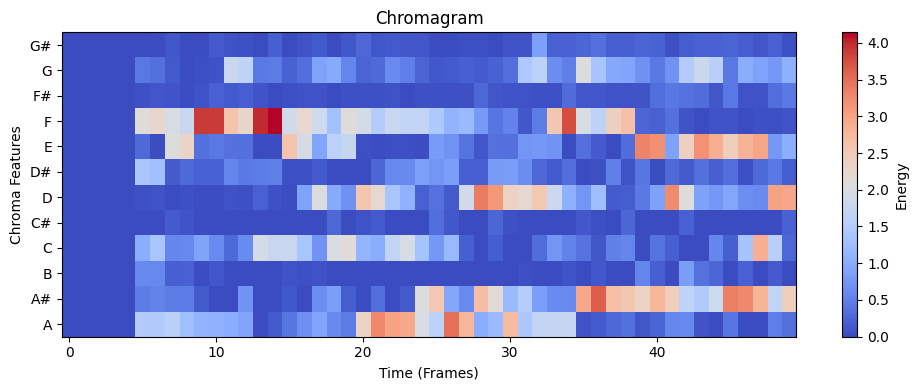

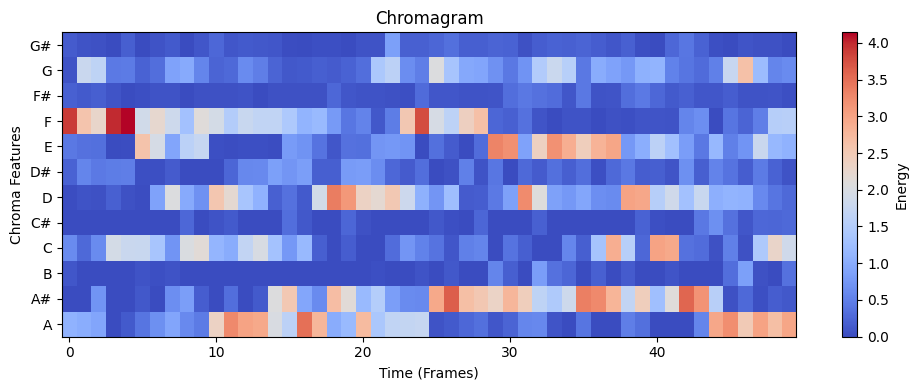

In [23]:
for i in range(2):
    chromagram(windows[i][2])

## Pre-processing des données

In [21]:
data = pickle.load(open('windows_bach.pkl', 'rb'))

In [50]:
np.array([data[i][2].flatten() for i in range(len(data))])[0]

array([0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
       0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
       0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
       0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
       0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
       0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
       0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
       0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
       0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
       0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
       0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
       0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
       1.48103e+00, 4.71290e-01, 6.07978e-01, 1.00695e+00, 1.65767e-03,
       5.11324e-02, 1.37932e+00, 2.86185e-01, 2.11538e+00, 4.979

In [56]:
def k_means_clustering(data, n_clusters=10):
    """
    Applies KMeans clustering to the data.
    """
    data_flattened = np.array([data[i][2].flatten() for i in range(len(data))])
    identifiers = np.array([(data[i][0],data[i][1]) for i in range(len(data))])
    kmeans = KMeans(n_clusters = n_clusters, random_state=42)
    clusters = kmeans.fit_predict(data_flattened)
    results = np.column_stack((identifiers, clusters))
    return results

In [57]:
k_means_clustering(data, n_clusters=10)

array([['01_bach/CrossComp-0056_01_bach_11_bwv_880_in_fmaj.mp3', '0',
        '8'],
       ['01_bach/CrossComp-0056_01_bach_11_bwv_880_in_fmaj.mp3', '10',
        '8'],
       ['01_bach/CrossComp-0056_01_bach_11_bwv_880_in_fmaj.mp3', '20',
        '8'],
       ...,
       ['01_bach/CrossComp-0071_01_bach_trio_gdur_bwv_586.mp3', '2440',
        '7'],
       ['01_bach/CrossComp-0071_01_bach_trio_gdur_bwv_586.mp3', '2450',
        '7'],
       ['01_bach/CrossComp-0071_01_bach_trio_gdur_bwv_586.mp3', '2460',
        '7']], dtype='<U110')